In [1]:
import numpy as np
import scienceplots
from matplotlib import pyplot as plt
import pandas as pd
import os
import scipy as sp
import seaborn as sns
import json
import yaml
import functools
import itertools

In [3]:
prefix='sockperf-eval'

In [4]:
res_dir = os.listdir(f'../{prefix}')[0]
res_dir = f"{prefix}/{res_dir}"

# PIDSTAT

## Global CPU usage

   cpu  client  run       wait       used   core
0   18       1    1   0.111111   2.277778  184.5
1   18      50    1  12.722222  31.722222  622.5
2   18     100    1  12.722222  29.055556  637.5


<AxesSubplot: xlabel='client'>

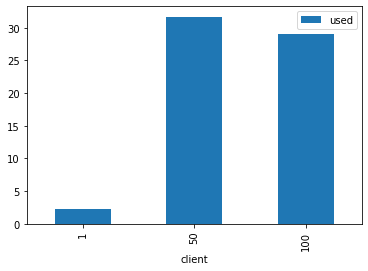

In [34]:
pidstat = pd.read_csv(f"../{res_dir}/summary/server/cpu-pidstat.csv")

# Compute sum of CPU usage of pids at a given timestamp
tmp = pidstat.groupby(['cpu', 'client', 'timestamp', 'run']).sum(numeric_only=True).reset_index()

# Compute median values per run for each cpu, client couple
tmp = tmp.groupby(['cpu', 'client', 'run']).median(numeric_only=True).reset_index()

# Normalize CPU usage to 100%
ncpu = 18
tmp[['used', 'wait']] /= 18

print(tmp)
tmp.plot.bar(x='client', y='used')

## Per core CPU usage

In [66]:
pidstat = pd.read_csv(f"../{res_dir}/summary/server/cpu-pidstat.csv")

In [67]:
# Compute sum of CPU usage of pids at a given timestamp
tmp = pidstat.groupby(['cpu', 'client', 'core', 'timestamp', 'run']).sum(numeric_only=True).reset_index()

# Compute median values per run for each cpu, client couple
tmp = tmp.groupby(['cpu', 'client', 'core', 'run']).median(numeric_only=True).reset_index()

In [68]:
tmp_per_client = {}
for client in tmp.client.unique():
    tmp_per_client[client] = tmp[tmp.client == client]

<AxesSubplot: xlabel='core'>

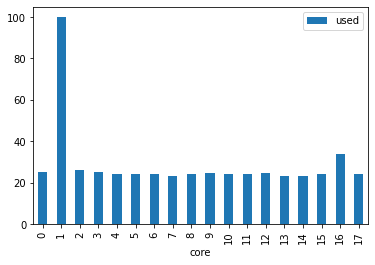

In [69]:
tmp_per_client[100].plot.bar(x='core', y='used')

   cpu  client  run  core       wait       used
0   18       1    1   8.5   0.111111   2.333333
1   18      50    1   8.5  12.611111  31.788611
2   18     100    1   8.5  12.718333  28.931944


<AxesSubplot: xlabel='client'>

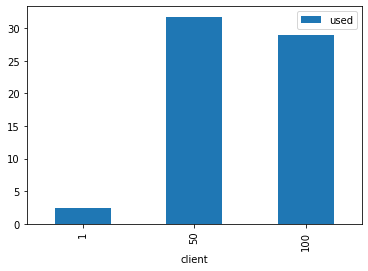

In [70]:
tmp_global = tmp.groupby(['cpu', 'client', 'run']).mean().reset_index()
print(tmp_global)
tmp_global.plot.bar(x='client', y='used')

# CPU SAR (IDLE-based)

In [51]:
cpu = pd.read_csv(f"../{res_dir}/summary/server/cpu-sar.csv")
cpu = cpu[cpu.core != -1]
tmp = cpu.groupby(['cpu', 'client', 'core', 'run']).median().reset_index()
# tmp = tmp.groupby(['cpu', 'client']).sum().reset_index()
# ncpu = 18
# tmp[['idle', 'usr', 'kernel', 'softirq']] /= ncpu
tmp['used'] = 100 - tmp['idle']


In [53]:
tmp
tmp_per_client = {}
for client in tmp.client.unique():
    tmp_per_client[client] = tmp[tmp.client == client]

<AxesSubplot: xlabel='core'>

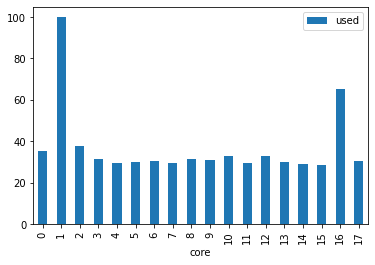

In [57]:
tmp_per_client[100].plot.bar(x='core', y='used')

# Latency with SOCKPERF

   client        99th      99.9th     99.99th    99.999th
0       1    0.229176    0.288566    1.659841    2.189469
1      50   32.554845   59.406914   63.578147   65.139727
2     100  495.292679  526.934510  542.972890  545.360648


<AxesSubplot: xlabel='client'>

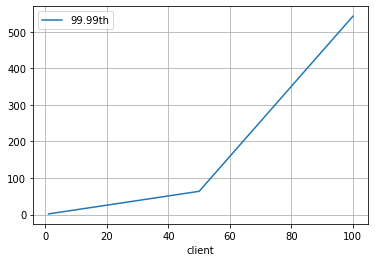

In [72]:
latency = pd.read_csv(f"../{res_dir}/summary/clients/sockperf-1.csv")
tails = ['99th', '99.9th', '99.99th', '99.999th',]
cols = ['min', 'median', 'max'] + tails
latency = latency.groupby(['cpu', 'client', 'run']).median().reset_index()
latency[cols] /= 1000
print(latency[['client'] + tails])
latency.plot(x='client', y='99.99th', grid=True)

# Throughput

   cpu  client  run     rxpck/s  txpck/s    rxkB/s    txkB/s
0   18       1    1   26152.500  13167.0  0.171491  0.011394
1   18      50    1  770012.000  57771.5  7.959787  0.117012
2   18     100    1  699014.765  45499.0  7.865810  0.107815


<AxesSubplot: xlabel='client'>

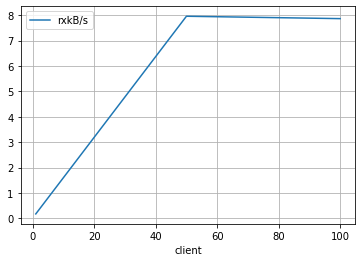

In [73]:
net = pd.read_csv(f"../{res_dir}/summary/server/throughput-sar.csv")
net = net[net.iface == 'wg']
net = net.groupby(['cpu', 'client', 'run']).median(numeric_only=True).reset_index()
net['rxkB/s'] = net['rxkB/s'] * 8 / 1e6
net['txkB/s'] = net['txkB/s'] * 8 / 1e6
print(net)
net.plot(x='client', y='rxkB/s', grid=True)